# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from nltk.corpus import wordnet as wn
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras
import keras.utils
from keras import utils as np_utils
from keras.utils import to_categorical
from keras.layers import Embedding
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_colwidth', -1)
from keras_contrib.layers import CRF

Using TensorFlow backend.
C:\Users\gujabeen\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


### Function to read file and split the data into two cols; sentences and NER tags

In [2]:
def readfile(filename):
    '''
    read file
    '''
    f = open(filename)
    data = []
    sentence = []
    label = []
    for line in f:
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
            if len(sentence) > 0:
                data.append((sentence, label))
                sentence = []
                label = []
            continue
        splits = line.split(' ')
        sentence.append(splits[0])
        label.append(splits[-1][:-1])
    if len(sentence) > 0:
        data.append((sentence, label))
        sentence = []
        label = []
    return data

# Data Preparation

In [3]:
train=readfile('eng.train') # training data
test=readfile('eng.testb') # test data
colnames=['List1', 'List2'] 
# Training dataset
df = pd.DataFrame(data=train)
df.columns = ['List1', 'List2']

In [4]:
df

,List1,List2
0,"[EU, rejects, German, call, to, boycott, British, lamb, .]","[I-ORG, O, I-MISC, O, O, O, I-MISC, O, O]"
1,"[Peter, Blackburn]","[I-PER, I-PER]"
2,"[BRUSSELS, 1996-08-22]","[I-LOC, O]"
3,"[The, European, Commission, said, on, Thursday, it, disagreed, with, German, advice, to, consumers, to, shun, British, lamb, until, scientists, determine, whether, mad, cow, disease, can, be, transmitted, to, sheep, .]","[O, I-ORG, I-ORG, O, O, O, O, O, O, I-MISC, O, O, O, O, O, I-MISC, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,"[Germany, 's, representative, to, the, European, Union, 's, veterinary, committee, Werner, Zwingmann, said, on, Wednesday, consumers, should, buy, sheepmeat, from, countries, other, than, Britain, until, the, scientific, advice, was, clearer, .]","[I-LOC, O, O, O, O, I-ORG, I-ORG, O, O, O, I-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O, I-LOC, O, O, O, O, O, O, O]"
...,...,...
14036,"[on, Friday, :]","[O, O, O]"
14037,"[Division, two]","[O, O]"
14038,"[Plymouth, 2, Preston, 1]","[I-ORG, O, I-ORG, O]"
14039,"[Division, three]","[O, O]"


In [5]:
# Test dataset for validation 
val_df = pd.DataFrame(data=test)
val_df.columns = ['List1', 'List2']

In [6]:
val_df

,List1,List2
0,"[SOCCER, -, JAPAN, GET, LUCKY, WIN, ,, CHINA, IN, SURPRISE, DEFEAT, .]","[O, O, I-LOC, O, O, O, O, I-PER, O, O, O, O]"
1,"[Nadim, Ladki]","[I-PER, I-PER]"
2,"[AL-AIN, ,, United, Arab, Emirates, 1996-12-06]","[I-LOC, O, I-LOC, I-LOC, I-LOC, O]"
3,"[Japan, began, the, defence, of, their, Asian, Cup, title, with, a, lucky, 2-1, win, against, Syria, in, a, Group, C, championship, match, on, Friday, .]","[I-LOC, O, O, O, O, O, I-MISC, I-MISC, O, O, O, O, O, O, O, I-LOC, O, O, O, O, O, O, O, O, O]"
4,"[But, China, saw, their, luck, desert, them, in, the, second, match, of, the, group, ,, crashing, to, a, surprise, 2-0, defeat, to, newcomers, Uzbekistan, .]","[O, I-LOC, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, I-LOC, O]"
...,...,...
3448,"[That, is, why, this, is, so, emotional, a, night, for, me, ,, "", Charlton, said, .]","[O, O, O, O, O, O, O, O, O, O, O, O, O, I-PER, O, O]"
3449,"["", It, was, the, joy, that, we, all, had, over, the, period, ,, that, I, shared, with, people, that, I, grew, to, love, ,, that, I, treasure, most, ,, "", he, added, .]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
3450,"[Charlton, managed, Ireland, for, 93, matches, ,, during, which, time, they, lost, only, 17, times, in, almost, 10, years, until, he, resigned, in, December, 1995, .]","[I-PER, O, I-LOC, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
3451,"[He, guided, Ireland, to, two, successive, World, Cup, finals, tournaments, and, to, the, 1988, European, championship, finals, in, Germany, ,, after, the, Irish, beat, a, well-fancied, England, team, 1-0, in, their, group, qualifier, .]","[O, O, I-LOC, O, O, O, I-MISC, I-MISC, O, O, O, O, O, O, I-MISC, O, O, O, I-LOC, O, O, O, I-MISC, O, O, O, I-LOC, O, O, O, O, O, O, O]"


In [7]:
# List of Sentences
sentences=df["List1"].values.tolist() #converting whole dataframe to list to pass it from tokenizer

In [8]:
sentences[0]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [9]:
# List of tags
tags=df["List2"].values.tolist()

In [10]:
# List of sentences and tags for validation ( Tesz Dataset)

val_sentences=val_df["List1"].values.tolist()
val_tags=val_df["List2"].values.tolist()

### Tokenizer Function

This class allows to vectorize a text corpus, by turning each text into either a sequence of integers
(each integer being the index of a token in a dictionary) or into a vector where the coefficient for 
 each token could be binary, based on word count, based on tf-idf

#### texts_to_sequences
Transforms each text in texts to a sequence of integers.
So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index

#### pad_sequences 

It is used to ensure that all sequences in a list have the same length. By default this is done by padding 0
in the beginning of each sequence until each sequence has the same length as the longest sequence

In [11]:

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(sentences)  
# number of common words: here we have 21010 common words
common_words = len(word_tokenizer.word_index) + 1
embedded_sentences = word_tokenizer.texts_to_sequences(sentences)
max_len=max([len(seq) for seq in embedded_sentences]) 
X=np.array(pad_sequences(embedded_sentences,padding='post'))


#same as above methods (NER tags preparation)
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(tags)
embedded_labels = label_tokenizer.texts_to_sequences(tags)
y=np.array(pad_sequences(embedded_labels,padding='post'))
max_len_labels=len(label_tokenizer.word_index)+1



    

In [12]:

# to_categorical is used to convert array of labeled data(from 0 to nb_classes-1) to one-hot vector.
y = [to_categorical(i, num_classes=max_len_labels) for i in y]
X_tr=X
y_tr=y

# Model Setup

###  Bi-LSTM network with an embedding layer

inputs: The input(s) of the model: a keras.Input object or list of keras.Input objects. <br/>

output_dim: Integer. Dimension of the dense embedding.<br />

input_length: Length of input sequences, when it is constant. This argument is required if you are going to connect Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed). <br />

The first hidden layer will have 100 memory units and the output layer will be a fully connected layer that 
outputs one value per timestep.

TimeDistributed wrapper layer is used around the output layer so that one value per timestep can be predicted given
the full sequence provided as input. This requires that the LSTM hidden layer returns a sequence of values (one per timestep)
rather than a single value for the whole input sequence.<br />
Softmax function: “returns a probability distribution over the target classes in a multiclass classification problem”  <br />

This is a multi-class classification problem, the categorical log loss (categorical_crossentropy in Keras) is used.
The efficient ADAM optimization algorithm isused to find the weights and the accuracy metric is calculated and reported
each epoch.

In [13]:

input = Input(shape=(max_len,))
model = Embedding(input_dim=common_words, output_dim=max_len, input_length=max_len)(input)  # 113-dim embedding
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(model)  # variational biLSTM
model = TimeDistributed(Dense(max_len_labels, activation="softmax"))(model)  # softmax output layer
crf = CRF(max_len_labels)  # CRF layer
out = crf(model)
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

C:\Users\gujabeen\Anaconda3\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
C:\Users\gujabeen\Anaconda3\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy


In [14]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 113)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 113, 113)          2374130   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 113, 200)          171200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 113, 9)            1809      
_________________________________________________________________
crf_1 (CRF)                  (None, 113, 9)            189       
Total params: 2,547,328
Trainable params: 2,547,328
Non-trainable params: 0
_________________________________________________________________


The LSTM will be trained for 5 epochs.
One epoch is when an entire dataset is passed both forward and backward through the neural network only once
The validation split variable in Keras is a value between [0..1]. Keras proportionally split your training set 
by the value of the variable.The first set is used for training and the 2nd set for validation after each epoch.

In [15]:

history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5, validation_split=0.1, verbose=1)


C:\Users\gujabeen\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 12636 samples, validate on 1405 samples
Epoch 1/5
12636/12636 [==============================] - 237s 19ms/step - loss: 0.9447 - crf_viterbi_accuracy: 0.8711 - val_loss: 0.3679 - val_crf_viterbi_accuracy: 0.9784
Epoch 2/5
12636/12636 [==============================] - 232s 18ms/step - loss: 0.1882 - crf_viterbi_accuracy: 0.9781 - val_loss: 0.1133 - val_crf_viterbi_accuracy: 0.9805
Epoch 3/5
12636/12636 [==============================] - 189s 15ms/step - loss: 0.1014 - crf_viterbi_accuracy: 0.9783 - val_loss: 0.0906 - val_crf_viterbi_accuracy: 0.9805
Epoch 4/5
12636/12636 [==============================] - 106s 8ms/step - loss: 0.0858 - crf_viterbi_accuracy: 0.9783 - val_loss: 0.0803 - val_crf_viterbi_accuracy: 0.9805
Epoch 5/5
12636/12636 [==============================] - 99s 8ms/step - loss: 0.0771 - crf_viterbi_accuracy: 0.9783 - val_loss: 0.0736 - val_crf_viterbi_accuracy: 0.9805


In [16]:
hist = pd.DataFrame(history.history) # Saving all data from the model in dataframe to interpret results

# Visualization of results

In [17]:
def visualize_results(value, vali_value, label):
    plt.plot(value)
    plt.plot(vali_value)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.title(label)
    plt.show()

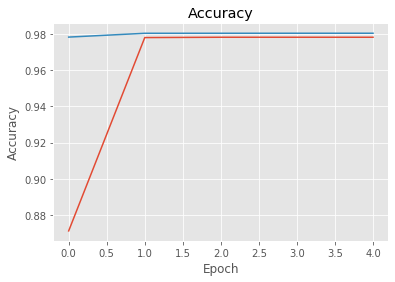

In [18]:
visualize_results(hist["crf_viterbi_accuracy"], hist["val_crf_viterbi_accuracy"], 'Accuracy')
# visualize_results(hist["precision_m"], hist["val_precision_m"], 'Precison')
# visualize_results(hist["recall_m"], hist["val_recall_m"], 'Recall')
# visualize_results(hist["f1_m"], hist["val_f1_m"], 'F1-Score')

# Evaluation of the model

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
def add_padding_sentences(sentence,max_length): 
    val_input_sequences=word_tokenizer.texts_to_sequences(sentence) #padding
    val_input_sequences=np.array(pad_sequences(val_input_sequences,padding='post', maxlen=max_length))
    return val_input_sequences
def add_padding_labels(labels,max_length):
    val_tag_sequence=label_tokenizer.texts_to_sequences(labels)
    val_tag_sequence=np.array(pad_sequences(val_tag_sequence,padding='post', maxlen=max_length))
    return val_tag_sequence
def predict_model(sequences): #predict 
    test_pred=model.predict(sequences)
    test_pred=test_pred.argmax(axis=-1)
    return test_pred
def flatten_values(value): 
    y_true_=value.flatten()
    return_index= np.vectorize(label_tokenizer.index_word.get)(y_true_)
    return return_index


In [21]:
val_input_sequences=add_padding_sentences(val_sentences,max_len)
val_tag_sequences= add_padding_labels(val_tags,max_len)
test_pred = predict_model(val_input_sequences)
y_true_index=flatten_values(val_tag_sequences)
test_pred_index=flatten_values(test_pred)
# print(classification_report(y_true_index, test_pred_index))

In [22]:
print(classification_report(y_true_index, test_pred_index))

C:\Users\gujabeen\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        None       0.99      1.00      0.99    343765
       b-loc       0.00      0.00      0.00         6
      b-misc       0.00      0.00      0.00         9
       b-org       0.00      0.00      0.00         5
       i-loc       0.00      0.00      0.00      1918
      i-misc       0.00      0.00      0.00       909
       i-org       0.00      0.00      0.00      2490
       i-per       0.00      0.00      0.00      2771
           o       0.82      0.89      0.85     38316

    accuracy                           0.97    390189
   macro avg       0.20      0.21      0.21    390189
weighted avg       0.95      0.97      0.96    390189



Observations: BAD RESULTS because 'keras_contrib.layers import CRF' is deprecated. We need to use tensorflow CRF
    